# **1. Loading & Cleaning Data**

In [202]:
import yfinance as yf

gold_ticker = yf.Ticker("GC=F")

df = gold_ticker.history(period="1mo", interval='5m')

# df.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

display(df.head(3))
display(df.shape)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-08-18 18:00:00-04:00,2549.699951,2549.899902,2508.399902,2545.000000,1253,0.0,0.0
2024-08-18 18:05:00-04:00,2545.000000,2545.000000,2541.500000,2543.899902,675,0.0,0.0
2024-08-18 18:10:00-04:00,2543.699951,2544.600098,2542.800049,2544.300049,411,0.0,0.0


(5718, 7)

# **Creating Variables**

In [203]:
WINDOW = 7

# RRR is 1 SL = TP = 1 STD
PNL = {
    'WIN': 1,
    'LOSS': -1
}

SIGNALS = {
    'BUY': 1,
    'SELL': -1
}

STD_FACTORS = {
    'ENTRY': 2.2,
    'SL': 1, # is calculated from entry
    'TP': 1 # is calculated from entry
}

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [204]:
# Low
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

df.dropna(inplace=True)
df.reset_index(inplace=True)

display(df.head())

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits,Mean_L,STD_L,Z-Score_L,Mean_H,STD_H,Z-Score_H
0,2024-08-18 18:30:00-04:00,2543.000000,2544.100098,2541.899902,2543.199951,286,0.0,0.0,2531.542864,17.800941,0.581825,2544.857143,2.345785,-0.322726
1,2024-08-18 18:35:00-04:00,2543.000000,2544.000000,2542.600098,2543.699951,197,0.0,0.0,2536.428606,14.836966,0.415954,2544.014300,0.747085,-0.019141
2,2024-08-18 18:40:00-04:00,2543.699951,2543.699951,2542.300049,2543.100098,137,0.0,0.0,2536.542899,14.885545,0.386761,2543.828578,0.610270,-0.210771
3,2024-08-18 18:45:00-04:00,2543.000000,2544.199951,2542.600098,2544.000000,265,0.0,0.0,2536.514335,14.871722,0.409217,2543.771415,0.540737,0.792505
4,2024-08-18 18:50:00-04:00,2543.800049,2544.500000,2543.500000,2543.600098,152,0.0,0.0,2536.785749,14.996819,0.447712,2543.814279,0.590015,1.162209


### Overview

<Axes: ylabel='Z-Score'>

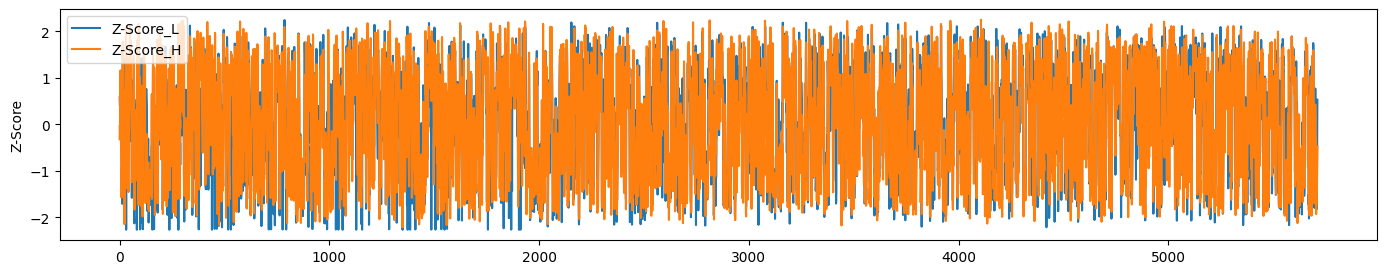

In [205]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', figsize=(17, 3), ylabel="Z-Score")

Z-Score_L
False    0.972339
True     0.027661
Name: proportion, dtype: float64

,Z-Score_L,Z-Score_H
max,2.244099,2.250915
min,-2.267684,-2.217209


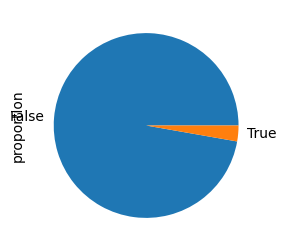

In [206]:
stats = (abs(df['Z-Score_L']) > 2).value_counts(normalize=True)

display(stats)

stats.plot(kind='pie', figsize=(3, 3))

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [207]:
df['Signal'] = 0  # Default to hold/no position
df.loc[df['Z-Score_L'] < -STD_FACTORS['ENTRY'], 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[df['Z-Score_H'] > STD_FACTORS['ENTRY'], 'Signal']= SIGNALS['SELL']  # Sell signal

# **3. Implementing Stop Loss and Take Profit**

In [208]:
# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
in_trade = False
entry_price = 0.0

# [TODO] instead create a trade object that contains entry, tp and sl

for i in range(0, len(df)):
    if not in_trade: 
        # Check if there's a BUY signal
        if df.loc[i, 'Signal'] == SIGNALS['BUY']:
            in_trade = True
            entry_price = (df.loc[i, 'Mean_L']  - STD_FACTORS['ENTRY'] * df.loc[i, 'STD_L']) 
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['BUY'], entry_price]
        # Check if there's a SELL signal
        if df.loc[i, 'Signal'] == SIGNALS['SELL']:
            in_trade = True
            entry_price = (df.loc[i, 'Mean_H']  + STD_FACTORS['ENTRY'] * df.loc[i, 'STD_H'])
            df.loc[i, ['Position', 'Entry_Price']] = [SIGNALS['SELL'], entry_price]
    else:
        # Track price movement for Stop Loss or Take Profit
        # In case of BUY
        if df.loc[i, 'Signal'] == SIGNALS['BUY']:
            if df.loc[i, 'Low'] <= entry_price - STD_FACTORS['SL'] * df.loc[i, 'STD_L']:  # SL hit
                df.loc[i, 'Exit_Price'] = entry_price - STD_FACTORS['SL'] * df.loc[i, 'STD_L']
                df.loc[i, 'PnL'] = PNL['LOSS']
                in_trade = False  # Exit trade
            elif df.loc[i, 'High'] > entry_price + STD_FACTORS['TP'] * df.loc[i, 'STD_L']:  # TP hit
                df.loc[i, 'Exit_Price'] = entry_price + STD_FACTORS['TP'] * df.loc[i, 'STD_L']
                df.loc[i, 'PnL'] = PNL['WIN']
                in_trade = False  # Exit trade

        # In case of SELL
        if df.loc[i, 'Signal'] == SIGNALS['SELL']:
            if df.loc[i, 'High'] >= entry_price + STD_FACTORS['SL'] * df.loc[i, 'STD_H']:  # SL hit
                df.loc[i, 'Exit_Price'] = entry_price + STD_FACTORS['SL'] * df.loc[i, 'STD_H']
                df.loc[i, 'PnL'] = PNL['LOSS']
                in_trade = False  # Exit trade
            elif df.loc[i, 'Low'] < entry_price - STD_FACTORS['TP'] * df.loc[i, 'STD_H']:  # TP hit
                df.loc[i, 'Exit_Price'] = entry_price - STD_FACTORS['TP'] * df.loc[i, 'STD_H']
                df.loc[i, 'PnL'] = PNL['WIN']
                in_trade = False  # Exit trade

In [209]:
df['PnL'].sum()

10.0

# **4. Backtesting & Overview**

In [210]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
win_rate = round(trades['PnL'].value_counts(normalize=True).loc[1], 3)

print(f"Total Trades: {total_trades}")
print(f"Total Profit/Loss: {total_pnl} RR")
print(f"Win rate: {win_rate * 100}%")


Total Trades: 28
Total Profit/Loss: 10.0 RR
Win rate: 67.9%


<Axes: title={'center': 'PnL'}, ylabel='RR | %'>

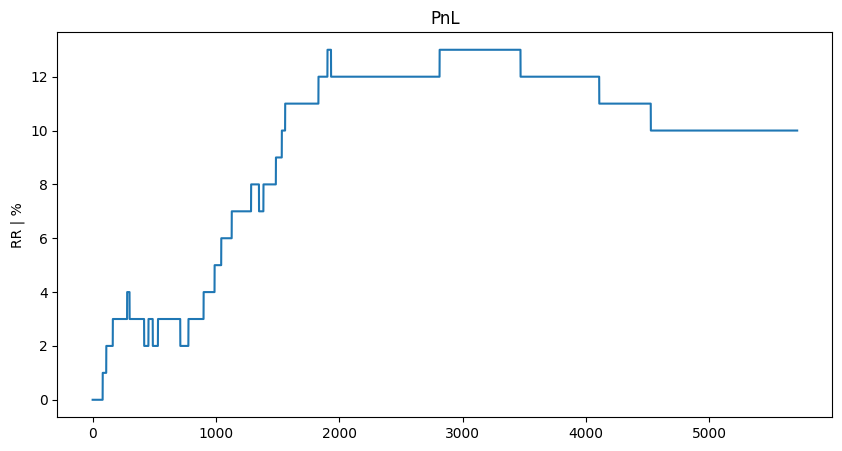

In [211]:
df['Cumulative_PnL'].plot(
    kind='line', 
    figsize=(10, 5), 
    title="PnL",
    ylabel="RR | %",
    # xticks= [x for x in range(1, len(df[df['PnL'] != 0]) + 1)]
)